## Population Report: Census | Flood affected regions

We can integrate the flood model's predictive geometries with census data, specifically population figures, to gain insights into the number of people at risk in areas highly susceptible to flooding.

In [1]:
from google.cloud import bigquery
import pandas as pd

# get table prediction from BQ for St Louis, MO flood
client = bigquery.Client()
query = ("SELECT * FROM `gee-workshop-042023.flood_model_houston.stl_flattened_p100`")
df = client.query(query).to_dataframe()
df

,dem,prob_yes,x,y,geometry
0,62.42086,0.526498,-90.333651,38.604445,POLYGON ((-90.33371836882549 38.60451214201893...
1,105.58979,0.071759,-90.375851,38.555078,POLYGON ((-90.37591802900758 38.55514511684360...
2,144.93044,0.070138,-90.393267,38.675827,POLYGON ((-90.39333376178114 38.67589419193462...
3,131.47906,0.083261,-90.399697,38.684367,POLYGON ((-90.39976418618984 38.68443335304602...
4,108.70827,0.184616,-90.527636,38.572023,POLYGON ((-90.52770283848793 38.57209001467405...
...,...,...,...,...,...
5191013,107.89130,0.086543,-90.520804,38.772694,POLYGON ((-90.52087051255369 38.77276030079215...
5191014,94.19385,0.095158,-90.233712,38.610983,POLYGON ((-90.23377885614029 38.61104993724486...
5191015,102.31014,0.089589,-90.499235,38.788171,"POLYGON ((-90.4993017973495 38.78823753030658,..."
5191016,102.83649,0.188228,-90.467083,38.571223,"POLYGON ((-90.467149675306 38.57128946831986, ..."


In [2]:
from io import BytesIO
import pandas as pd
from google.cloud import storage

# get census tract population from derived census table w/ population + geometry
bucket_name = "stlouis-workshop"
blob_name = "flood/assets-tract-table.csv"
storage_client = storage.Client()
bucket = storage_client.bucket(bucket_name)
blob = bucket.blob(blob_name)

blob_data = BytesIO(blob.download_as_bytes())
census_population = pd.read_csv(blob_data)

In [3]:
from shapely import wkt

# Convert the 'geometry' column from string to actual geometry
census_population['geometry'] = census_population['geometry'].apply(wkt.loads)
df['geometry'] = df['geometry'].apply(wkt.loads)

In [4]:
import geopandas as gpd

# Convert DataFrames to GeoDataFrames
census_population_gdf = gpd.GeoDataFrame(census_population, geometry='geometry')
df_gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Filter df_gdf to include only rows with prob_yes > 0.2 based on manual threshold
high_risk_gdf = df_gdf[df_gdf['prob_yes'] > 0.2]

# Perform a spatial join to find which census tract each flood area belongs to
joined_gdf = gpd.sjoin(high_risk_gdf, census_population_gdf, how='inner', predicate='within')

# Drop duplicates based on GEOID so that each census tract is counted only once
unique_tracts_affected = joined_gdf.drop_duplicates(subset='GEOID')[['GEOID', 'Tract', 'County', 'Population']]

# Display or save the report
#print(unique_tracts_affected)

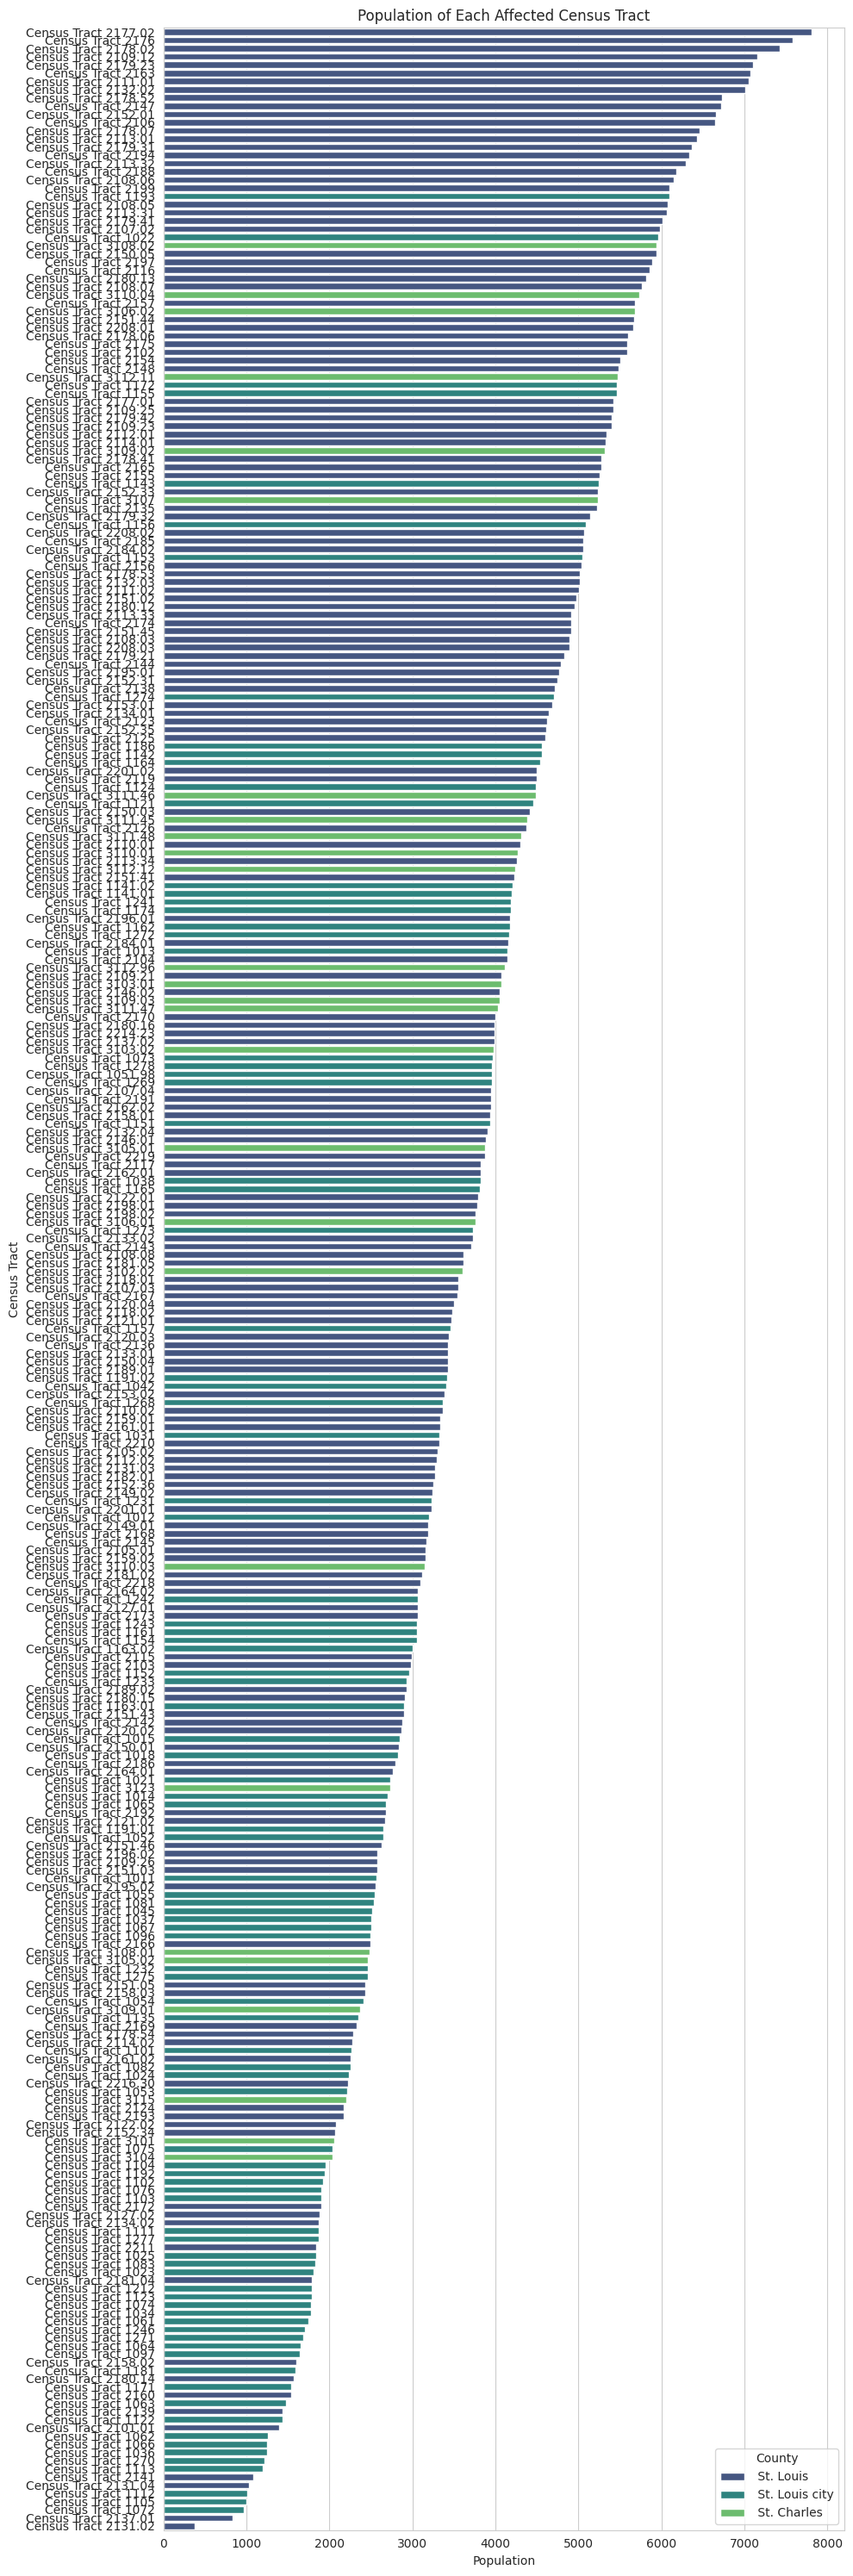

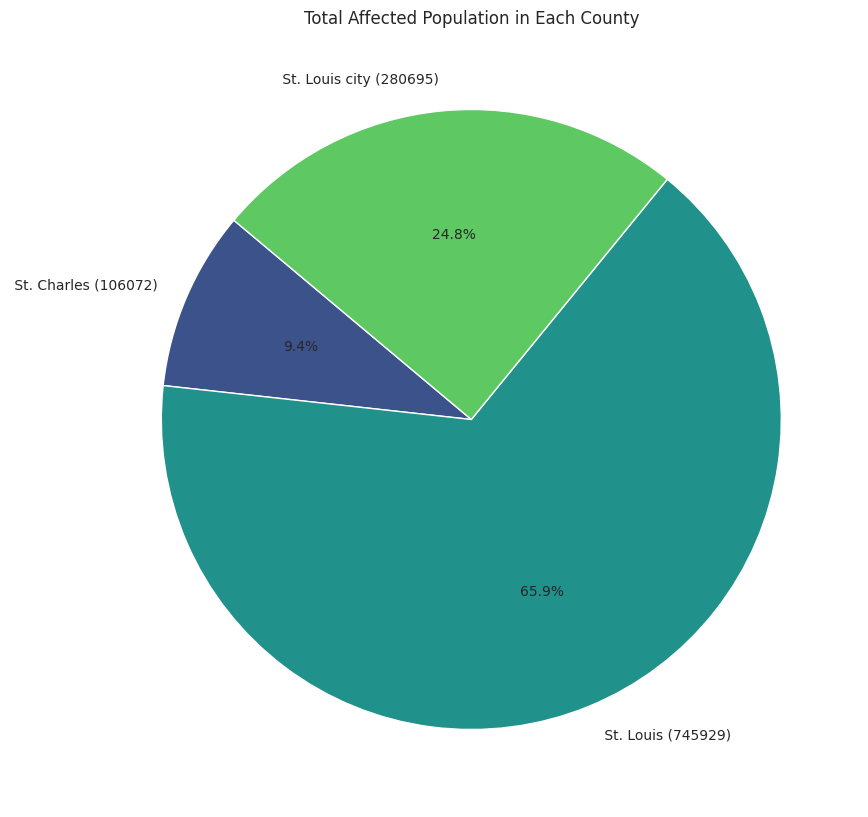

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Styling
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10,30)

# 1. Bar chart for Population of each affected census tract
sns.barplot(data=unique_tracts_affected.sort_values('Population', ascending=False), 
            y='Tract', x='Population', hue='County', dodge=False, palette='viridis')
plt.title('Population of Each Affected Census Tract')
plt.xlabel('Population')
plt.ylabel('Census Tract')
plt.legend(title='County')
plt.tight_layout()
plt.show()

# 2. Pie chart for total affected population in each county
county_population = unique_tracts_affected.groupby('County')['Population'].sum()
colors = sns.color_palette('viridis', len(county_population))
plt.pie(county_population, labels=county_population.index + ' (' + county_population.values.astype(str) + ')',
        colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Total Affected Population in Each County')
plt.show()


## Building Report: Building Amount & Type | Flood Regions

We can also combine the predictive geometries from the flood model with data from OpenStreetMap to identify building polygons in our target area. This allows us to estimate the number of buildings potentially impacted in areas most vulnerable to flooding.

In [6]:
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Polygon

coordinates = [[-92.79583046462477, 36.713291047659105],
               [-88.35735390212477, 36.713291047659105],
               [-88.35735390212477, 40.01998830501556],
               [-92.79583046462477, 40.01998830501556],
               [-92.79583046462477, 36.713291047659105]]

# Create a Polygon from the coordinates
polygon = Polygon(coordinates)

# Use the osmnx `geometries_from_polygon()` function to get the list of building geometries in the AOI.
buildings = ox.geometries_from_polygon(polygon, tags={'building': True})

# Convert the list of building geometries to a GeoDataFrame.
buildings_gdf = gpd.GeoDataFrame(buildings)
print(f'Total buildings in AOI: {len(buildings_gdf)}')

/var/tmp/ipykernel_80251/2252691958.py:15: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_polygon(polygon, tags={'building': True})


Total buildings in AOI: 351132


In [7]:
# Set CRS for both GeoDataFrames
buildings_gdf = buildings_gdf.set_crs("EPSG:4326")
df_gdf = df_gdf.set_crs("EPSG:4326")

# Filter df_gdf to include only rows with prob_yes > 0.2
high_risk_gdf = df_gdf[df_gdf['prob_yes'] > 0.2]

# Use a spatial join to identify buildings intersecting with flood areas
affected_buildings_gdf = gpd.sjoin(buildings_gdf[['building','geometry']], high_risk_gdf, how="inner", predicate="intersects")
unique_affected_buildings = affected_buildings_gdf.index.unique()
print(f"Number of unique buildings affected: {len(unique_affected_buildings)}")
#print(unique_affected_buildings)

Number of unique buildings affected: 5583


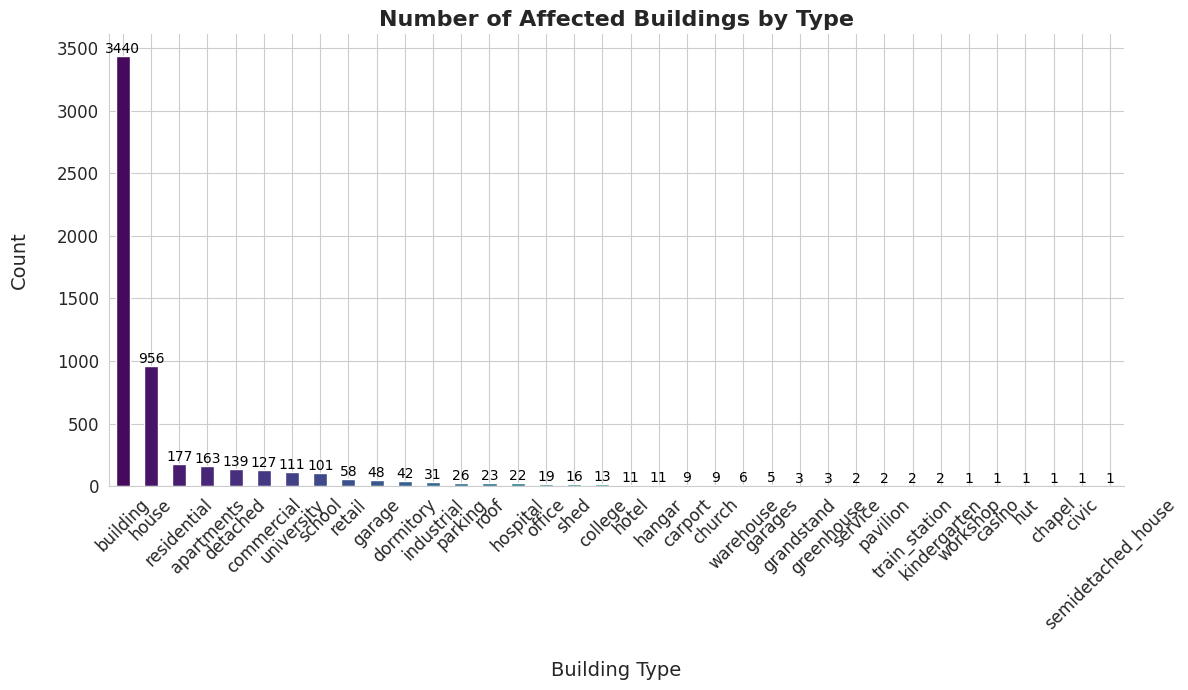

In [8]:
import seaborn as sns

# Drop duplicates based on the 'geometry' column to get unique affected buildings
unique_affected_buildings_gdf = affected_buildings_gdf.drop_duplicates(subset='geometry').copy()

# Set up seaborn style
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(12, 7))

# Generate the bar plot with a color palette
unique_affected_buildings_gdf['building'] = unique_affected_buildings_gdf['building'].replace('yes', 'building')
colors = sns.color_palette("viridis", n_colors=unique_affected_buildings_gdf['building'].nunique())
affected_buildings_counts = unique_affected_buildings_gdf['building'].value_counts()
affected_buildings_counts.plot(kind='bar', ax=ax, color=colors)

# Annotate bar heights
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.1,
            '{:1.0f}'.format(height),
            ha="center", va='bottom', fontsize=10, color='black')

# Set title and labels with improved fonts
plt.title("Number of Affected Buildings by Type", fontsize=16, fontweight='bold')
plt.xlabel("Building Type", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20

# Remove right and top borders for cleaner look
sns.despine()

plt.tight_layout()
plt.show()
